# Measuring Biodiversity on Agricultural Land with Remote Sensing Data (Part II)

__Published: 14/05/2024__

## Imports

In [1]:
# Vector processing
import geopandas as gpd
import shapely
import osgb

# Raster processing
import rasterio
import rasterio.warp
import rasterio.mask
import rasterio.plot
import rasterio.features
import rasterio.sample
from rasterio import windows
import pyproj
import xarray as xr
import rioxarray

# Calcs and modelling
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
from glob import glob
import warnings
import os
from pystac_client import Client
import boto3
from dask.distributed import Client as DaskClient
from dask.distributed import print as distributed_print
import subprocess
import functools
import sys
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

DATA_BASE_PATH = '../../../data/Agric_data/NPMS_Locations/' # all data under this path (global)
WORKING_CRS = 'EPSG:3035'


## Introduction

In the previous article, a method linking remote sensing parameters on agricultural land to biodiversity survey data [1] was adapted to UK Pollinator Monitoring Scheme (PoMS) data. In order to retain sufficient PoMS sampling locations whilst ensuring proximity to fields used for spring cereal cultivation in the chosen survey year (2019), quite a large study area around each PoMS location was adopted. This potentially has the effect of weakening correlations between small-scale biodiversity metrics and larger-scale agricultural intensity proxies. Whilst the authors of [1] did find significant correlations between biodiversity and remote sensing-derived measurements, those correlations were not observed using the adapted method presented in the last notebook. Amongst the conclusions was the concept that the adapted study area was likely too large to maintain a possible relationship between the measured variables.

Here, that conclusion is explored by applying a very similar process as presented before to a different biodiversity dataset, the UK National Plant Monitoring Scheme (NPMS). The authors of [1] also found significant correlations between biodiversity metrics for vascular plants and agricultural intensity parameters, and the greater quantity of NPMS sampling locations (compared to the PoMS dataset) means that a much smaller study area can be used. This enables a higher-fidelity reproduction of the original methodology, whilst retaining a reasonable sample size.

__Objectives__
The objectives are the same as those laid out in the last article, this time applied to NPMS data:
1. Reproduce the method described in [1] from scratch in this Python-based notebook environment.
2. Extend that method such that it can be applied to NPMS samples.
3. Evaluate whether a significant correlation exists between remote sensing-derived parameters and NPMS biodiversity metrics.

## Methods

### Set datapoint used for demo graphs and maps

This is done retrospectively taking one of the directories generated in the subsequent download process. 

Expand the cell below to show the code snippet.

In [78]:
# Select an AOI with data
aoi_dirs = [i for i in os.listdir(DATA_BASE_PATH) if os.path.isdir(os.path.join(DATA_BASE_PATH, i)) and ('metadata.csv' in os.listdir(os.path.join(DATA_BASE_PATH, i)))]
aoi_dir = aoi_dirs[3]

# Construct location code from path
location_code = int(aoi_dir.split('_')[1])

# Select one date's data for that AOI
dates = [i for i in os.listdir(os.path.join(DATA_BASE_PATH, aoi_dir)) if '_' in i] # Just date directories
date = dates[30]

# Construct full path
aoi_date_download_path = os.path.join(DATA_BASE_PATH, aoi_dir, date)

### Biodiversity data: UK National Plant Monitoring Scheme

The NPMS is a national-scale plant monitoring survey in which volunteers visit randomly allocated locations and record plant observations in around five plots at each location, amounting to typically thousands of locations surveyed each year [2]. The data was downloaded from the UK CEH Environmental Information Data Centre and is read in a preprocessed below [3].

Locations at which sensitive species were found are dropped because geolocation data was spatially blurred by the NPMS for these observations, which would make the remainder of the process here invalid. These records correspond to less than 1% of the dataset.

Note that some of the post-processing of biodiversity data is done in the results section, per site in the filtered dataset, which is more efficient than calculating metrics on the entire dataset here.

In [2]:
########################################################################
# Read in occurrences
occurrences = pd.read_csv('../../../data/Agric_data/Plant/data/occurrences_2015to2022.csv').set_index('id')

# Drop spatially blurred observations
occurrences = occurrences[occurrences['sensitivity_precision'].isna()].drop(columns=['sensitivity_precision','record_status'])
########################################################################


########################################################################
# Read in sample data 
_temp = pd.read_csv('../../../data/Agric_data/Plant/data/sampleinfowithlatlong_2015to2022.csv', index_col=0, dtype={'location_id':'Int64'})
sample_info = gpd.GeoDataFrame(_temp, geometry=gpd.GeoSeries.from_xy(_temp['LONGITUDE'], _temp['LATITUDE']), crs='EPSG:4326').set_index('id')
sample_info = sample_info.to_crs(WORKING_CRS)
sample_info['date_start'] = pd.to_datetime(sample_info['date_start'])
sample_info['year'] = sample_info['date_start'].dt.year

# Define study regions for data download later
buffer_radius = 100
sample_info['study_zone'] = sample_info.geometry.buffer(buffer_radius)
sample_info['study_zone_bbox'] = shapely.box(*np.split(sample_info['study_zone'].bounds.values, 4, axis=1)).flatten()
########################################################################


########################################################################
# Read in sample attributes 
sample_attributes = pd.read_csv('../../../data/Agric_data/Plant/data/sampleattributes_2015to2022.csv').set_index('sample_attribute_id')

# Get samples which are tagged with arable agriculture attributes
arable_samples = sample_attributes[(sample_attributes['caption'] == 'NPMS Habitat') & sample_attributes['text_value'].isin(['Arable field margins', 'Arable margins'])]
########################################################################

To arrive at a set of study locations to download satellite imagery and agricultural land use data for, the sample data is filtered, keeping locations with arable attribute tags, and years for which agricultural land use data is available, and dropping duplicates:

In [20]:
arable_samples_loc_yr_unique = sample_info.loc[arable_samples['sample_id'].unique()][['geometry', 'year', 'date_start', 'study_zone', 'study_zone_bbox', 'survey_id']].drop_duplicates(subset=['geometry', 'date_start'])
arable_samples_loc_yr_unique = arable_samples_loc_yr_unique[(arable_samples_loc_yr_unique['year'] <= 2020) & (arable_samples_loc_yr_unique['year'] >= 2018)]
arable_samples_loc_yr_unique.head()

,geometry,year,date_start,study_zone,study_zone_bbox,survey_id
id,,,,,,
2459716,POINT (3347328.898 3112656.417),2018,2018-05-18,"POLYGON ((3347428.898 3112656.417, 3347428.417...",POLYGON ((3347428.8984529204 3112556.417126075...,87
3374584,POINT (3613310.248 3353483.205),2018,2018-04-01,"POLYGON ((3613410.248 3353483.205, 3613409.767...",POLYGON ((3613410.2482128586 3353383.205378609...,155
3425299,POINT (3587828.892 3171514.315),2018,2018-04-22,"POLYGON ((3587928.892 3171514.315, 3587928.410...",POLYGON ((3587928.8916301527 3171414.315482463...,154
3432713,POINT (3509784.399 3428080.153),2018,2018-04-23,"POLYGON ((3509884.399 3428080.153, 3509883.918...","POLYGON ((3509884.399378102 3427980.153094661,...",154
3440706,POINT (3436618.076 2977607.276),2018,2018-04-29,"POLYGON ((3436718.076 2977607.276, 3436717.594...","POLYGON ((3436718.075516487 2977507.276026127,...",154


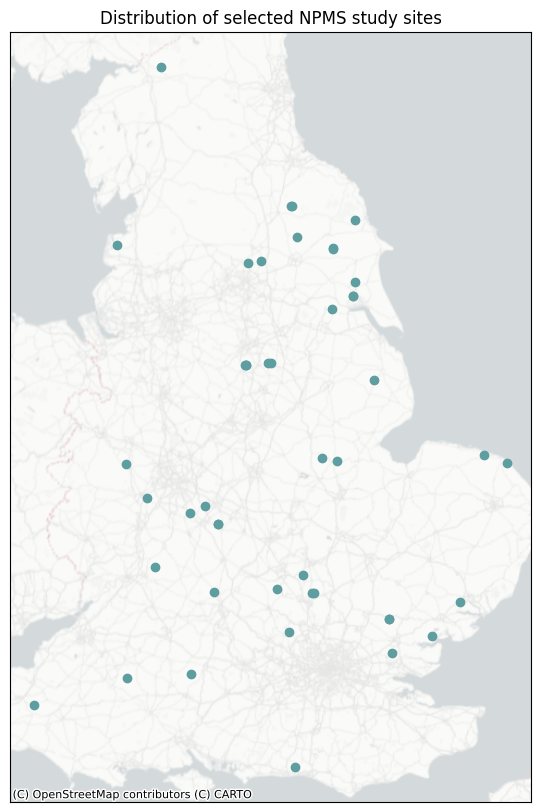

In [10]:
ax = arable_samples_loc_yr_unique.loc[[int(i.split('_')[1]) for i in aoi_dirs]].drop_duplicates('geometry').plot(figsize=(10, 10), edgecolor=None, color='cadetblue')
cx.add_basemap(ax, crs=arable_samples_loc_yr_unique.crs, source=cx.providers.CartoDB.PositronNoLabels)
ax.set_xticks([])
ax.set_yticks([])
plt.title('Distribution of selected NPMS study sites')
plt.show()

### Agricultural land use data: CROME

This subsection is largely identical to that presented in the last article.

Spring cereal fields were used for the study on which this notebook is based [1]. Here, the Crop Map of England (CROME) [4] was used to identify spring cereal fields based on agricultural land use codes. 

CROME data was downloaded for each location, for years corresponding to the NPMS sampling dates (note that CROME designations are constant within each year).

The CROME download is handled outside of this script, see https://github.com/twhit1/quant_ecolo/blob/dev/docs/get_crome_2019.sh as an example.

In [41]:
SPRING_CEREAL_LUCODES = ['AC01', # barley
                         'AC19', # oats
                         'AC24', # rye
                         'AC30', # triticale
                         'AC32'] # wheat


Locations have already been filtered for those marked "arable (field) margins" by NPMS volunteers, and here are further filtered for locations in proximity of spring cereals. 

Specifically, a minimum of three CROME cells labelled "spring cereal" intersecting a 100 metre radius of the NPMS sampling location is required. The study area size was determined by trial and error, by minimizing the study area whilst retaining sufficient sampling locations. This was done by repeatedly running the following code snippet with different study areas and recording the count of remaining NPMS locations (not shown here).

Compared to the previous notebook which used a circle of radius 2km, the study area used here is significantly closer to that used in the original study [1], which consisted of four Sentinel-2 pixels at the center of the field in which biodiversity survey data was collected. Requiring at least three CROME cells in proximity to the NPMS sampling locations ensures a significant presence of agricultural cereal cropping activity in the vicinity (CROME data is defined on a ~40m side-length hex grid). 

In [ ]:
sc_aoi_dirs = [] # correspond to NPMS sample IDs
for i, location_path in enumerate(glob(os.path.join(DATA_BASE_PATH, '*', 'CROME'))):
    # Read in agricultural land use data
    crome_data = gpd.read_file(location_path).to_crs(WORKING_CRS)
    crome_data = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)]

    # Datapoint references
    aoi_dir = location_path.split('/')[-2]
    id = int(aoi_dir.split('_')[1])

    # Check spring cereal intersection
    sc_cells_in_radius = crome_data[crome_data.intersects(arable_samples_loc_yr_unique.loc[id, 'study_zone'])]
    if len(sc_cells_in_radius) >= 3:
        sc_aoi_dirs.append(aoi_dir)

An example study location (with surrounding CROME spring cereal cells) is shown below.

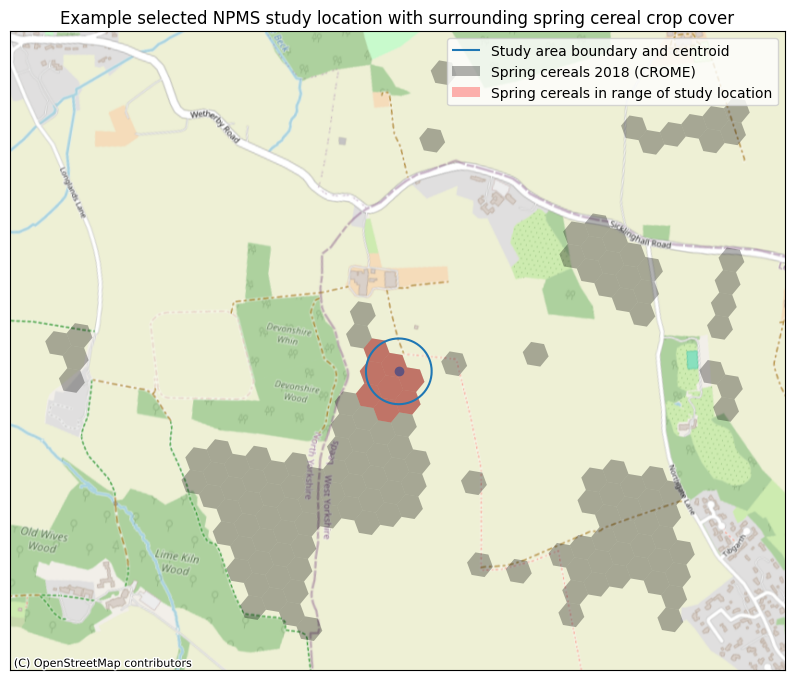

In [79]:
location_path = f'../../../data/Agric_data/NPMS_Locations/{aoi_dir}/CROME'
crome_data = gpd.read_file(location_path).to_crs(arable_samples_loc_yr_unique.crs)
    
# filter for spring cereals
crome_data = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)]
sc_cells_in_radius = crome_data[crome_data.intersects(arable_samples_loc_yr_unique.loc[location_code, 'study_zone'])]

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
crome_data.plot(ax=ax, color='k', alpha=0.3, edgecolor=None)
cx.add_basemap(ax, crs=arable_samples_loc_yr_unique.crs, source=cx.providers.OpenStreetMap.Mapnik, zoom=15)

arable_samples_loc_yr_unique.loc[[location_code]].plot(ax=ax)
arable_samples_loc_yr_unique.loc[[location_code]]['study_zone'].exterior.plot(ax=ax, label='Study area boundary and centroid')
sc_cells_in_radius.plot(ax=ax, color='red', alpha=0.3, label='Spring cereals in range of study location')



legend_handles = [mpl.patches.Patch(facecolor='k', alpha=0.3, label=f"Spring cereals {location_path.split('/')[-2].split('_')[-1]} (CROME)"),
                  mpl.patches.Patch(facecolor='r', alpha=0.3, label="Spring cereals in range of study location")]

plt.legend(handles=ax.get_legend_handles_labels()[0] +  legend_handles)

ax.set_xticks([])
ax.set_yticks([])

plt.title('Example selected NPMS study location with surrounding spring cereal crop cover')
plt.show()



### Download Sentinel-2 imagery

For each NPMS location and survey year, the corresponding Sentinel-2 crops (thematic maps, visual and vegetation index inputs) is downloaded.

Expand the cell below to see the methodology.

In [ ]:
def get_pystack_aws_sessions():
    '''Initiates a pystac client and rasterio AWS session to coordinate requests.'''
    client = Client.open("https://earth-search.aws.element84.com/v1")
    aws_session = rasterio.session.AWSSession(boto3.Session(), requester_pays=True)

    return client, aws_session


def read_S3(href, aoi_bbox_geodetic):
    '''Downloads the data and metadata corresponding to an acquisition, based on a 
    reference and spatial filter (defined as a shapely bbox in EPSG:4326).'''
    with rasterio.open(href) as src:
        # Transform window to src crs
        transform_geodetic_to_s2 = pyproj.Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
        src_bbox = shapely.ops.transform(transform_geodetic_to_s2, aoi_bbox_geodetic)
        window = rasterio.windows.from_bounds(*conform_bbox(src_bbox),
                                              transform=src.transform).round_lengths()
        data = src.read(window=window) 
        src_profile = src.profile
        src_profile.update({'width': window.width,
                            'height': window.height,
                            'transform': rasterio.windows.transform(window, src.transform)})

    return {'data': data, 'profile': src_profile}
    
def get_geodetic_bbox(bbox, bbox_crs):
    '''Transforms a bounding box (as a shapely box) in a given CRS to EPSG:4326'''
    # Get transformer for bbox
    transform_working_to_geodetic = pyproj.Transformer.from_crs(pyproj.CRS(bbox_crs), 
                                                                pyproj.CRS('EPSG:4326'), 
                                                                always_xy=True).transform
    # Get transformed bbox (in EPSG:4326)
    bbox_geodetic_coords = transform_working_to_geodetic(*bbox.exterior.xy)
    bbox_geodetic = shapely.geometry.Polygon(np.stack(bbox_geodetic_coords, axis=1))

    return bbox_geodetic

def conform_bbox(shapely_bbox):
    '''Returns coords as left, bottom, right, top from a shapely box.
    
    This is a utility function to go between shapely and (rasterio and pystac)'''
    shapely_bbox_coords = shapely_bbox.exterior.coords.xy
    rio_stac_bbox_coords = [min(shapely_bbox_coords[0]), # Align shapely and pystac conventions
                             min(shapely_bbox_coords[1]), 
                             max(shapely_bbox_coords[0]), 
                             max(shapely_bbox_coords[1])]
            
    return rio_stac_bbox_coords
    
def search_stac(client, aoi_bbox_geodetic=None, datetime=None, max_items=1000, query=None):
    '''searchs a stac collection with using client, filtering based on aoi_bbox_geodetic
    (a shapely box in EPSG:4326), and based on datetime. See pystac docs for client.search 
    API details.

    Note that pystac client expands datetimes, i.e. from the docs "2017 
    expands to 2017-01-01T00:00:00Z/2017-12-31T23:59:59Z".
    
    query examples:
      filter on processing baseline (see https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/processing-baseline)
        query = {'s2:processing_baseline': {"neq": "05.00"}}

      filter on cloud cloverage
        query=['eo:cloud_cover<50']
    '''
    search = client.search(max_items=max_items, # speed up
                           collections=['sentinel-2-l2a'],
                           query=query,
                           bbox=conform_bbox(aoi_bbox_geodetic),
                           datetime=datetime)

    if search.matched() == max_items:
        print('Did not receive complete results. Consider increasing max_items kwarg ' + \
          f'(currently {max_items}).')

    return search


def item_covers_aoi(stac_item, aoi_geodetic):
    '''Returns true/false depending on whether the acquisition geometry fully covers the
    AOI.'''
    
    return shapely.geometry.shape(stac_item.geometry).contains(aoi_geodetic)

# Filter on clouds
def pass_clouds_snow(scl_data, max_cloud_perc=None):
    '''Returns true/false depending on whether the area proportion of the acquisition which
    is cloudy (according to the S2 cloud detection algorithm) is less than max_cloud_perc.
    
    Also includes snow/ice (SCL code 11).'''
    medium_cloud_prob = np.sum(scl_data == 8)
    high_cloud_prob = np.sum(scl_data == 9)
    snow_ice = np.sum(scl_data == 11)

    return (100 * ((medium_cloud_prob + high_cloud_prob + snow_ice) / np.size(scl_data))) < max_cloud_perc

def clean_dir(path):
    '''Clears up directories if download is re-run.'''
    files = os.listdir(path)
    if len(files) > 0:
        for file in files:
            distributed_print(f'### Cleaning (removing) {file}')
            os.remove(os.path.join(path, file))

def calculate_evi2(nir_data, red_data, profile):
    '''Returns the vegetation index EVI2 and corresponding raster profile.'''
    QUANT_VAL = 10000
    # Calculate evi2
    evi2 = 2.5 * ((nir_data / QUANT_VAL).astype(np.float32) - (red_data / QUANT_VAL).astype(np.float32)) / ((nir_data / QUANT_VAL).astype(np.float32) + 2.4*(red_data / QUANT_VAL).astype(np.float32) + 1)
    evi2_profile = {**profile, **{'nodata':np.nan, 'dtype': 'float32'}}

    return {'data': evi2, 'profile': evi2_profile}

def get_reprojected_profile(src_profile, target_crs, target_width=None, target_height=None, target_res=None):
    '''Calculates necessary changes to an arbritary source profile (a dictionary
    based on a rasterio read) to write to a target CRS or target width, height.
    
    Note that the rasterio method to do this is not ideal; open issue here
    https://github.com/rasterio/rasterio/issues/3009'''
    transformer = rasterio.transform.AffineTransformer(src_profile['transform']) 
    left, top = transformer.xy(0,0, offset='ul')
    right, bottom = transformer.xy(src_profile['height'], src_profile['width'], offset='ul')
    
    # Get default transform
    transform, width, height = rasterio.warp.calculate_default_transform(src_profile['crs'], 
                                                                            target_crs, 
                                                                            src_profile['width'], 
                                                                            src_profile['height'], 
                                                                            left=left,
                                                                            bottom=bottom,
                                                                            right=right,
                                                                            top=top,
                                                                            dst_width=target_width,
                                                                            dst_height=target_height,
                                                                            dst_resolution=target_res)

    # Update profile with new crs, transform and dimensions
    transform, width, height = rasterio.warp.aligned_target(transform, width, height, target_res)
    new_profile = {k:v for k, v in src_profile.items()}
    new_profile.update({'crs': target_crs,
                        'transform': transform,
                        'width': width,
                        'height': height})

    return new_profile
    
def trim_raster(to_trim_path, geometry):
    '''Overwrites to_trim_path, trimming to (shapely) geometry defined in same CRS as raster.'''
    with rasterio.open(to_trim_path) as src:
        data, masked_transform = rasterio.mask.mask(src, [geometry], crop=True, all_touched=True)
        profile = src.profile
        
    profile.update({"height": data.shape[1],
                    "width": data.shape[2],
                    "transform": masked_transform})

    with rasterio.open(to_trim_path, "w", **profile) as dest:
        dest.write(data)
        
def reproject_clip_write(data, source_profile, target_profile, full_write_path, aoi_geometry):
    '''Reprojects S2 data to working CRS and writes to disk, clipping to AOI geometry.'''
    target_profile.update({'nodata': source_profile['nodata'], 'dtype': source_profile['dtype'], 'count': source_profile['count']})
    with rasterio.open(full_write_path, 'w', **target_profile) as dst:
        for i in range(1, target_profile['count'] + 1):
            rasterio.warp.reproject(source=data,
                                    destination=rasterio.band(dst, i),
                                    src_transform=source_profile['transform'],
                                    src_crs=source_profile['crs'],
                                    resampling=rasterio.warp.Resampling.nearest)

    trim_raster(full_write_path, aoi_geometry)

def handle_download_errors(_download_items):
    '''Decorator to skip over errors, printing details to display for investigation later'''
    def log_and_skip_errors(_dir_name):
        try:
            return _download_items(_dir_name)
        except Exception as e:
            distributed_print(f'Location: {_dir_name} :: ERROR (skipping) ' + str(e))
            return None

    return log_and_skip_errors

# Some constants / global scope objects
band_names = ['red', 'nir', 'visual'] # S2 bands to be downloaded
MAX_ITEMS = 1000 # Max items returned by the each STAC server request (this is in a 1 year period)
max_cloud_perc = 10 # Max allowable cloud / snow pixels
client, aws_session = get_pystack_aws_sessions()

@handle_download_errors
def download_items(dir_name):
    '''Downloads  S2 data for a given NPMS location, with directory of structure: location_{NPMS sample ID}_{NPMS sample year}.'''
    sample_id = int(dir_name.split('_')[1])
    sample_year = dir_name.split('_')[2]
    data_path =  f'../../../data/Agric_data/NPMS_Locations/{dir_name}/'    
    distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year} :: Starting processing')

    # Skip this location if it was already processed
    if os.path.exists(os.path.join(data_path, 'metadata.csv')):
        distributed_print(f'Location: {dir_name} :: Already processed, skipping')
        return None
        
    # Get search results
    true_aoi_bbox = arable_samples_loc_yr_unique.loc[sample_id]['study_zone_bbox'] # in projected coords
    # buffer this by a pixel so that there are no missing corners in the data download (this can happen because of reprojections and finite resolution imagery)
    aoi_bbox = true_aoi_bbox.buffer(10, join_style=2)
    aoi_bbox_geodetic = get_geodetic_bbox(aoi_bbox, arable_samples_loc_yr_unique.crs) # in EPSG:4326
    search_results = search_stac(client, aoi_bbox_geodetic=aoi_bbox_geodetic, datetime=sample_year, 
                                 max_items=MAX_ITEMS, query={'s2:processing_baseline': {"neq": "05.00"}}) # Sentinel 2 reprocessing has not completed for 2019

    # Now iterate through dates with S2 acquisitions and download if they're good enough (intersect NPMS location fully and not too many clouds)
    for item in search_results.items():
        # Store date reference
        date_ref = item.datetime.strftime('%Y_%m_%d')
        base_write_path = os.path.join(data_path, date_ref)
        distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year}, date: {date_ref} :: Starting acquisition processing')
        
        # If there is already a folder here and it contains the right number of files, consider this date to be processed and skip
        if os.path.exists(base_write_path) and (len(os.listdir(base_write_path)) == (len(band_names) + 2)):
            distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year}, date: {date_ref} :: Already have correct number of files, skipping')
            continue

        # Require full coverage of the AOI
        if not item_covers_aoi(item, aoi_bbox_geodetic):
            continue
            
        # Next a cloud check
        s2_thematic = read_S3(item.assets['scl'].href, aoi_bbox_geodetic)
        if not pass_clouds_snow(s2_thematic['data'], max_cloud_perc=max_cloud_perc):
            distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year}, date: {date_ref} :: Too cloudy/snowy, skipping (more than {max_cloud_perc}% of image medium or high cloud probability or snow/ice)')
            continue

        # At this point we'll download the imagery, so create write directory if it does not already exist
        if not os.path.exists(base_write_path):
            os.mkdir(base_write_path)
        else:
            clean_dir(base_write_path)
            
        # Read data from S3 - already calculated scl so just add that to the dictionary instead of redownloading
        band_data = {band_name: read_S3(item.assets[band_name].href, aoi_bbox_geodetic) for band_name in band_names}
        band_data['scl'] = s2_thematic
        band_data['evi2'] = calculate_evi2(band_data['nir']['data'], # Vegetation index
                                           band_data['red']['data'],
                                           band_data['nir']['profile'].copy())

        # Define a target profile, which each raster will be aligned with
        target_height, target_width = (band_data['red']['profile'][i] for i in ['height', 'width'])
        target_res = (-band_data['red']['profile']['transform'][4], band_data['red']['profile']['transform'][0])
        target_profile = get_reprojected_profile(band_data['red']['profile'], WORKING_CRS, target_width=target_width, 
                                                 target_height=target_height, target_res=target_res)
        
        # Write results, reprojecting everything into WORKING_CRS and trimming to the AOI bbox
        for band_name, data_profile in band_data.items():
            full_write_path = os.path.join(base_write_path, band_name + '.tif')
            reproject_clip_write(data_profile['data'], data_profile['profile'], target_profile, full_write_path, true_aoi_bbox) # clip to true aoi bbox
            distributed_print(f'Sample ID: {sample_id}, sample year: {sample_year}, date: {date_ref}, band: {band_name} :: Written to {full_write_path}')
            
    # Now create a file to hold any metadata we may want to add and also signals completion of this location's download            
    subprocess.run(['touch', os.path.join(data_path, 'metadata.csv')])
    
    return None

with rasterio.Env(aws_session):
    dask_client = DaskClient(threads_per_worker=4, n_workers=2)
    futures = []
    for dir in sc_aoi_dirs:
        future = dask_client.submit(download_items, dir)
        futures.append(future)
    
    dask_client.gather(futures)


The resulting data set for one location, on one date looks like this:

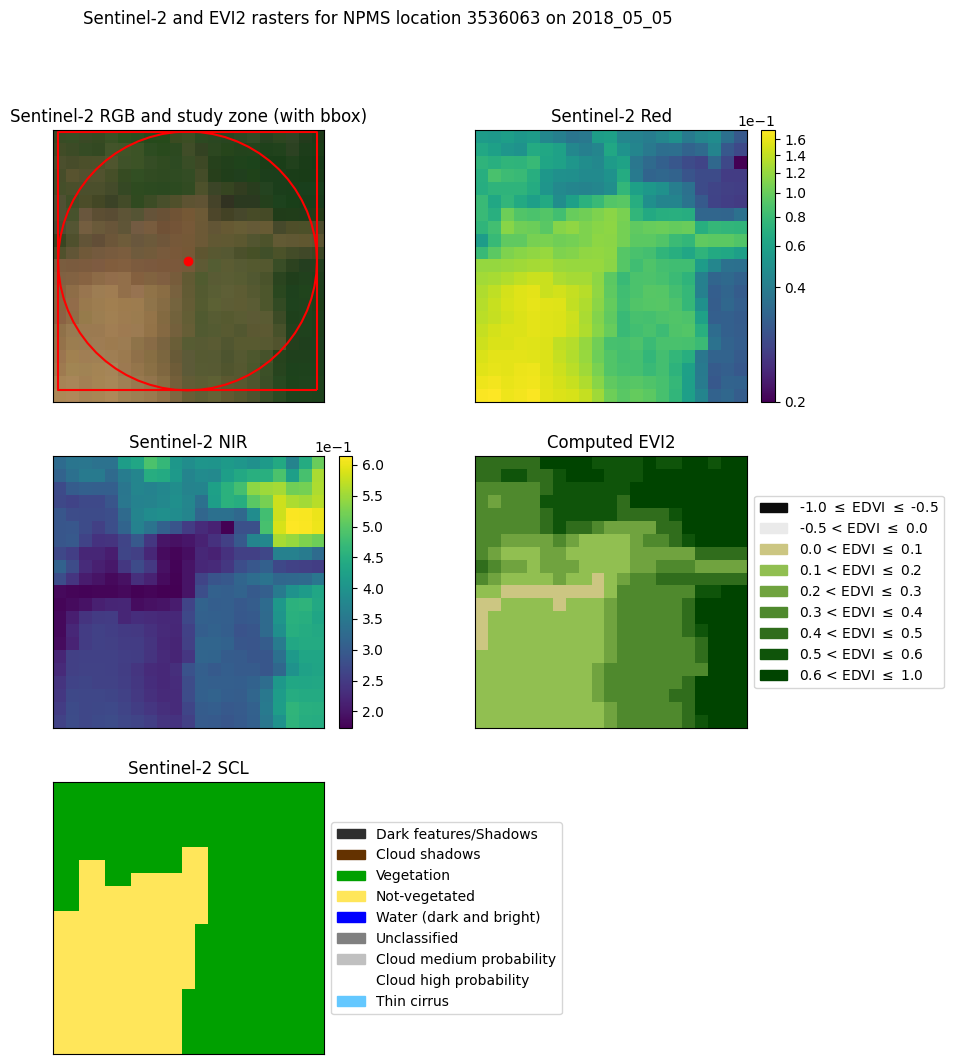

In [80]:
# Colormap as defined at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/
edvi_ranges = ['-1.0 $\leq$ EDVI $\leq$ -0.5',
               '-0.5 < EDVI $\leq$ 0.0',
               '0.0 < EDVI $\leq$ 0.1',
               '0.1 < EDVI $\leq$ 0.2',
               '0.2 < EDVI $\leq$ 0.3',
               '0.3 < EDVI $\leq$ 0.4',
               '0.4 < EDVI $\leq$ 0.5',
               '0.5 < EDVI $\leq$ 0.6',
               '0.6 < EDVI $\leq$ 1.0'
              ]

edvi_ranges_nums =  [-1.0, -0.5, 0.0,
                                    0.1,
                                    0.2,
                                    0.3,
                                    0.4,
                                    0.5,
                                    0.6,
                                    1.0]
edvi_colors = [[i/255 for i in [12, 12, 12]],
                        [i/255 for i in [234, 234, 234]],
                        [i/255 for i in [204, 198, 130]],
                        [i/255 for i in [145, 191, 81]],
                        [i/255 for i in [112, 163, 63]],
                        [i/255 for i in [79, 137, 45]],
                        [i/255 for i in [48, 109, 28]],
                        [i/255 for i in [15, 84, 10]],
                        [i/255 for i in [0, 68, 0]]]


# Color mapping for the scene classification
# Color map as described at https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

classification_names = ['Dark features/Shadows',
                        'Cloud shadows',
                        'Vegetation',
                        'Not-vegetated',
                        'Water (dark and bright)',
                        'Unclassified',
                        'Cloud medium probability',
                        'Cloud high probability',
                        'Thin cirrus']

classification_colors = [[i/255 for i in [47, 47, 47]],
                        [i/255 for i in [100, 50, 0]],
                        [i/255 for i in [0, 160, 0]],
                        [i/255 for i in [255, 230, 90]],
                        [i/255 for i in [0, 0, 255]],
                        [i/255 for i in [128, 128, 128]],
                        [i/255 for i in [192, 192, 192]],
                        [i/255 for i in [255, 255, 255]],
                        [i/255 for i in [100, 200, 255]]]

scl_cmap = mpl.colors.LinearSegmentedColormap.from_list('SCL map', classification_colors, len(classification_colors))
scl_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(classification_colors, 
                                                                                        classification_names)]
scl_norm = mpl.colors.BoundaryNorm([i - 0.5 for i in range(2, 12)], scl_cmap.N)



edvi_cmap = mpl.colors.LinearSegmentedColormap.from_list('EDVI map', edvi_colors, len(edvi_colors))
edvi_thematic_map = [mpl.patches.Patch(color=color, label=label) for color, label in zip(edvi_colors, edvi_ranges)]
edvi_norm = mpl.colors.BoundaryNorm(edvi_ranges_nums, edvi_cmap.N)


fig, axs = plt.subplots( nrows=3, ncols=2, figsize=(10, 12))
axs = axs.ravel()

views = ['visual', 'red', 'nir', 'evi2', 'scl']
titles = ['Sentinel-2 RGB and study zone (with bbox)', 'Sentinel-2 Red', 'Sentinel-2 NIR', 'Computed EVI2', 'Sentinel-2 SCL']
norms = [None, mpl.colors.PowerNorm(0.4), None, edvi_norm, scl_norm]
cmaps = [None, None, None, edvi_cmap, scl_cmap]

for i, view in enumerate(views):
    band_name = view
    with rasterio.open(os.path.join(aoi_date_download_path, view + '.tif')) as src:
        data_profile = {'data': src.read(), 'profile': src.profile}
        extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    
    ax = axs[i]
    if view in ['red', 'nir']:
        plot_data = data_profile['data'] / 10000 # Quantification value
    else:
        plot_data = data_profile['data']
        
    im = ax.imshow(np.squeeze(np.moveaxis(plot_data, 0, -1)), 
                   norm=norms[i],
                   cmap=cmaps[i], 
                   interpolation='nearest', # Just for image / display resolution mismatches, does not alter underlying values
                   extent=extent
                  )

    if view == 'visual':
        arable_samples_loc_yr_unique.loc[[location_code]].plot(ax=ax, color='red', label='NPMS study area centroid')
        arable_samples_loc_yr_unique.loc[[location_code]]['study_zone'].exterior.plot(ax=ax, label='study zone', 
                                                               color='red')
        arable_samples_loc_yr_unique.loc[[location_code]].set_geometry('study_zone_bbox')['study_zone_bbox'].exterior.plot(ax=ax, label='study zone bbox', 
                                                               color='red')
        
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], wrap=True)
    cbar = fig.colorbar(im, label=None, fraction=0.046, pad=0.04)
    if view == 'visual':
        cbar.ax.set_visible(False)
    elif view == 'scl':
        cbar.ax.set_visible(False)
        ax.legend(handles=scl_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
    elif view == 'evi2':
        cbar.ax.set_visible(False)
        ax.legend(handles=edvi_thematic_map, loc='center left', bbox_to_anchor=(1, 0.5))
        

axs[-1].set_axis_off()
plt.suptitle('Sentinel-2 and EVI2 rasters for NPMS location {} on {}'.format(location_code, date))
plt.show()

### Productivity and phenology parameters calculations


The methodology presented in this subsection is the same as that applied in the last article.

Before executing a productivity and phenology analysis based on Sentinel-2 imagery, a mask to remove "bad" pixels is defined.

In this section, the process is demonstrated for one example location, before looping through all NPMS localities and years.

Note that in place of the more frequently used NDVI index, the authors of [1] use the EVI2 index as a vegetation index, citing deficiencies with NDVI in relation to this use case.

$$
  EVI2 = 2.5*\frac{NIR - RED}{NIR + 2.4*RED + 1}
$$

#### Example for one location and date

Define a mask to select only the study area from a raster:

In [21]:
def rasterize_geoms(geoms, profile):
    '''Rasterizes geometries (geoms) according to a raster spec (profile).'''
    mask = rasterio.features.rasterize(geoms, 
                                        out_shape=(int(profile['height']), int(profile['width'])),
                                        fill=0,
                                        transform=profile['transform'],
                                        default_value=1, 
                                        dtype='uint8').astype(bool)
    return mask

def get_study_area_mask(aoi_dir):
    '''Returns a mask for the study area for a given location'''
    id = int(aoi_dir.split('_')[1])

    # Refer to arable_samples_loc_yr_unique as a global, which is the source of AOI specific metadata here
    study_zone_geom = arable_samples_loc_yr_unique.loc[id, 'study_zone']

    # Use the EVI2 profile for rasterize op
    evi2_path = glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile

    return rasterize_geoms([study_zone_geom], evi2_profile)


Define a mask to remove bad pixels (according to Sentinel-2 scene classification):

In [22]:
def get_scl_good_mask(aoi_dir, date):
    '''Returns a mask that filters out "bad" pixels according to the S2 scene classification.'''
    scl_path = os.path.join(DATA_BASE_PATH, aoi_dir, date, 'scl.tif')
    scl_raw = rasterio.open(scl_path).read(1)
    scl_good_mask = ~np.isin(scl_raw, [0, # No data
                                       1, # Saturated/defective pixel
                                       6, # Water
                                       9, # Cloud high prob
                                       11]) # Snow or ice

    return scl_good_mask

Define a mask to identify pixels that are never vegetated according to the Sentinel-2 scene classification map: 

In [23]:
def get_scl_never_veg_mask(aoi_dir):
    '''Returns a mask that filters out pixels not labelled as vegetation according to S2 SCL for the entire period.'''  
    def not_vegetated_mask(path):
        return rasterio.open(path).read(1) != 4

    base_path = os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'scl.tif')
    scl_never_veg = ~functools.reduce(np.logical_and, [not_vegetated_mask(i) for i in glob(base_path)])

    return scl_never_veg



Now get masks based on CROME crop designation. The method was originally applied to spring cereals [1], so return a spring cereal mask.

In [24]:
def get_crome_geoms(aoi_dir):
    '''Reads CROME data and converts to geometries on selected land-use codes.'''
    crome_path = os.path.join(DATA_BASE_PATH, aoi_dir, 'CROME')
    crome_data = gpd.read_file(crome_path)
    spring_cereal_geoms = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry.to_numpy()

    return spring_cereal_geoms


def get_farmed_area(aoi_dir):
    '''Reads CROME data and calculates the land area used for spring cereal culitvation and also (all types of) agriculture for this tile.'''
    crome_path = os.path.join(DATA_BASE_PATH, aoi_dir, 'CROME')
    crome_data = gpd.read_file(crome_path)
    spring_cereal_area = crome_data[crome_data['lucode'].isin(SPRING_CEREAL_LUCODES)].dissolve().explode().to_crs(WORKING_CRS).geometry.area.sum()
    agric_area = crome_data[crome_data['lucode'].str.startswith(('AC', 'CA', 'LG', 'NU', 'TC', 'SR'))].dissolve().explode().to_crs(WORKING_CRS).geometry.area.sum()

    return spring_cereal_area, agric_area

def get_cereal_masks(aoi_dir):
    '''Gets cereal land-use masks based on CROME data.'''
    # For this location get CROME data (constant on a year)
    spring_cereal_geoms = get_crome_geoms(aoi_dir)
    
    # Convert shapes to rasters based on raster profile of an evi2.tif for this location (should all have the same profile)
    evi2_path = glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif'))[0]
    evi2_profile = rasterio.open(evi2_path).profile
    
    # Generate spring cereal mask
    cereal_mask = rasterize_geoms(spring_cereal_geoms, evi2_profile)

    return cereal_mask



Apply masks to demo datapoint (single date in the timeseries) to show masking effect. Note that the composite mask is an intersection between the spring cereal mask, the study area mask and the Sentinel-2 scene classification mask (not never vegetated).

In [81]:
# Include the AOI mask and never_veg in the cereal mask for compactness
cereal_mask = get_cereal_masks(aoi_dir) & get_study_area_mask(aoi_dir) & get_scl_never_veg_mask(aoi_dir)

# Define relevant Xarray variables
evi2_paths = sorted(glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif')))
dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()

# Create masks (date-specific) based on SCL good pixels
good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(aoi_dir, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                 coords=evi2_xr.coords,
                                  dims=('time', 'y', 'x'))

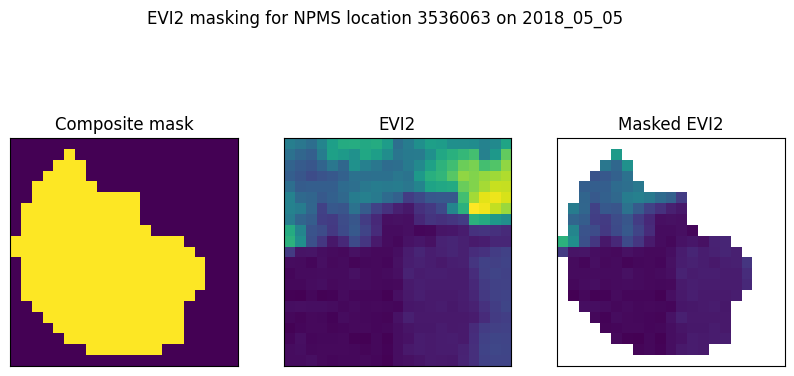

In [82]:
# Used chained where condition

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

ax = axs[0]
ax.imshow(xr.where(cereal_mask, xr.where(good_scl_masks_xr, 1, 0), 0).isel(time=0))
ax.set_title('Composite mask')

ax = axs[1]
ax.imshow(evi2_xr.isel(time=0))
ax.set_title('EVI2')

ax = axs[2]
ax.imshow(xr.where(cereal_mask, 
                      xr.where(good_scl_masks_xr, 
                               evi2_xr, 
                               np.nan), 
             np.nan).isel(time=0), interpolation=None, vmin=evi2_xr.isel(time=0).min(), vmax=evi2_xr.isel(time=0).max())
ax.set_title('Masked EVI2')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.suptitle("EVI2 masking for NPMS location {} on {}".format(aoi_dir.split('_')[1], date))

plt.show()

#### Time-series analysis for S2-based phenology and productivity parameters

It is now possible to calculate phenology and productivity parameters, based on the timeseries of masked vegetation indices.

The following shows the approach for a single NPMS location, using Python distributions of Xarray, and PhenoloPy. The analysis process shown here follows a PhenoloPy tutorial for a similar use case [5].

Note that several minor fixes to my local PhenoloPy functions were necessary for usage with the newer Xarray and NumPy releases used in this environment.

In [83]:
# Mask the EVI2 dataset
evi2_cereal_xr = xr.where(cereal_mask, 
                                  xr.where(good_scl_masks_xr, 
                                           evi2_xr, 
                                           np.nan), 
                          np.nan)

# Just do a bit of xarray preparation
evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})

# Redefine as a dataset
evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})

Now for the productivity/phenology calculation routine:

In [84]:
evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)

Group dataset interval: month via reducer: median
> Selecting year: 2018 to re-label times after groupby.
> Warning: dataset contains nan values. You should interpolate nan values next.
> Group successful.



In [85]:
evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2)

Outlier removal method: median with a user factor of: 2
> Generated roll window size less than 3, setting to default (3).
> Warning: dataset contains nan values. You may want to interpolate next.
> Outlier removal successful.



In [86]:
# set resample interval now, as a few functions require it
interval = '2W'
evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')

Correcting last datetime value to ensure adequate resampling output.
> Changing day of last datetime value in dataset to the 31st.
> Corrected late datetime value successfully.
Resampling dataset interval: 2W via reducer: median
> Warning: dataset contains nan values. You should interpolate nan values next.
> Resample successful.



In [87]:
evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)

Interpolating dataset using method: interpolate_na.
> Warning: dataset still contains nan values. The first and/or last time slices may be empty.
> Interpolation successful.

Checking and removing non-dominant year often introduced following resampling.
> More than one year detected in dataset. Removal non-dominant years.
> Checked and removed non-dominant year (if needed) successfully.


In [88]:
evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

Smoothing method: savitsky with window length: 3 and polyorder: 1.
> Warning: dataset contains nan values. You may want to interpolate next.
> Smoothing successful.



In [89]:
result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

Initialising calculation of phenometrics.

Beginning extraction of CRS metadata.
> Extracting CRS metadata.
> No CRS metadata found. Returning None.

Beginning calculation of phenometrics. This can take awhile - please wait.

Beginning calculation of peak of season (pos) values and times.
> Calculating peak of season (pos) values.
> Calculating peak of season (pos) times.
> Success!

Beginning calculation of fifth percentile veg index (bse_fifth_per) values.
> Calculating fifth percentile veg index (bse_fifth_per) values.
> Success!

Beginning calculation of amplitude of season (aos) values (times not possible).
> Calculating amplitude of season (aos) values.
> Success!

Beginning addition of CRS metadata.
> Adding CRS metadata.
> Could not add CRS metadata to data. Aborting.

Phenometrics calculated successfully!


Amplitude (aos) of the vegetation index id defined as the peak value (max observed in the season) minus the base value (fifth percentile of veg index) and was found to have the strongest correlation with farmer reported yields, alongside peak EVI2 ###CITE.

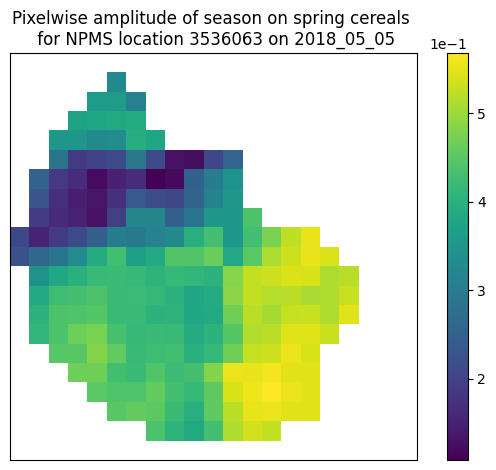

In [93]:
plt.figure()
plt.imshow(result.isel(phen_metric=2).to_numpy())
plt.title("Pixelwise amplitude of season on spring cereals \n for NPMS location {} on {}".format(aoi_dir.split('_')[1], date))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

The EVI2 timeseries and amplitude distributions for pixels labelled spring cereal according to CROME are presented below.

Similarly to the results shown in the last article, the pixel-wise EVI2 time series for this location clearly shows that despite a bimodal amplitude distribution, the majority of pixels exhibit a similar peak in the early summer period.

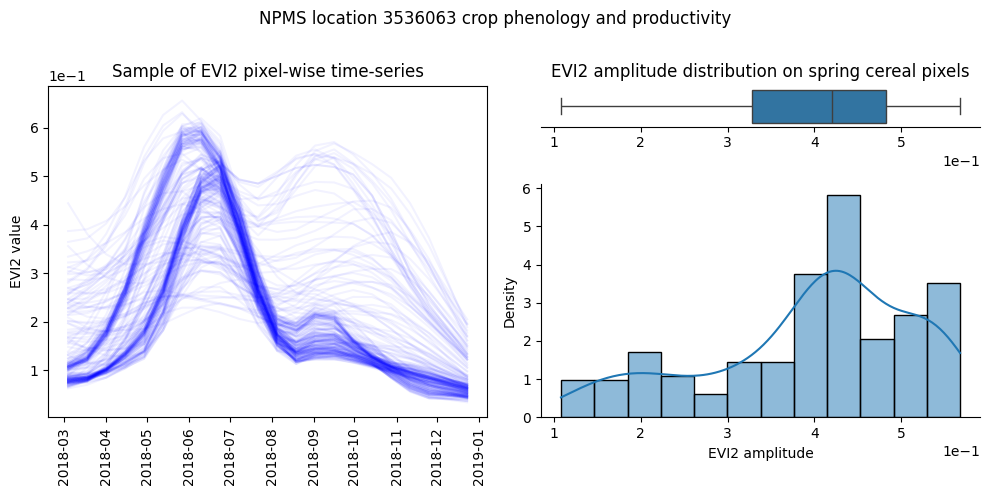

In [91]:
non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

# Create 2x2 sub plots
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=(.15, .85))

plt.figure(figsize=(10, 5))

ax = plt.subplot(gs[:, 0]) 
for pixel_ref in range(0, veg_index_timeseries.shape[1], 1):
    ax.plot(evi2_cereal_xr.time, veg_index_timeseries[:, pixel_ref], color='b', alpha=0.05)
ax.set_title('Sample of EVI2 pixel-wise time-series')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('EVI2 value')

_ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.boxplot(x=aos_vals, ax=_ax)
_ax.set(yticks=[])
sns.despine(ax=_ax, left=True)
_ax.set_title('EVI2 amplitude distribution on spring cereal pixels')

ax = plt.subplot(gs[1, 1]) 
ax.sharex(_ax)
sns.histplot(x=aos_vals, bins=12, kde=True, stat='density', ax=ax)
sns.despine(ax=ax)
ax.set_xlabel('EVI2 amplitude')

plt.suptitle("NPMS location {} crop phenology and productivity".format(aoi_dir.split('_')[1]))
plt.tight_layout()
plt.show()



The above method is now applied to the remaining NPMS locations and dates, and the median AOS across all spring cereal pixels is recorded for each.

Expand the cell below for the implementation.

In [92]:
def get_aos(aoi_dir):
    '''Returns the median evi2 amplitude on spring cereal fields in AOI'''
    distributed_print(f'Beginning processing for {aoi_dir}')

    # Get static mask (independent of time)
    cereal_mask = get_cereal_masks(aoi_dir) & get_study_area_mask(aoi_dir) & get_scl_never_veg_mask(aoi_dir)

    # Define relevant Xarray variables
    evi2_paths = sorted(glob(os.path.join(DATA_BASE_PATH, aoi_dir, '*', 'evi2.tif')))
    dates_xr = xr.Variable('time', pd.to_datetime([i.split('/')[-2] for i in evi2_paths], format='%Y_%m_%d'))
    evi2_xr = xr.concat([rioxarray.open_rasterio(path) for path in evi2_paths], dim=dates_xr).squeeze()
    
    # Create masks (date-specific) based on SCL good pixels
    good_scl_masks_xr = xr.DataArray(np.stack([get_scl_good_mask(aoi_dir, date) for date in dates_xr.to_index().strftime('%Y_%m_%d')]),
                                     coords=evi2_xr.coords,
                                      dims=('time', 'y', 'x'))

    # Mask the EVI2 dataset
    evi2_cereal_xr = xr.where(cereal_mask, 
                                      xr.where(good_scl_masks_xr, 
                                               evi2_xr, 
                                               np.nan), 
                              np.nan)

    # Now for the phenology and productivity calculations
    # as in the example above
    evi2_cereal_xr = evi2_cereal_xr.drop_vars('band')
    evi2_cereal_xr = evi2_cereal_xr.assign_coords({'spatial_ref': int(''.join([i for i in WORKING_CRS if i.isdigit()]))})
    evi2_cereal_xr = xr.Dataset({'veg_index': evi2_cereal_xr})
    evi2_cereal_xr = evi2_cereal_xr.assign_attrs({'crs': WORKING_CRS, 'grid_mapping': 'spatial_ref'})
    evi2_cereal_xr = phenolopy.group(evi2_cereal_xr)
    evi2_cereal_xr = phenolopy.remove_outliers(ds=evi2_cereal_xr, method='median', user_factor=2, z_pval=0.05)
    interval = '2W'
    evi2_cereal_xr = phenolopy.correct_last_datetime(evi2_cereal_xr, interval)
    evi2_cereal_xr = phenolopy.resample(evi2_cereal_xr, interval=interval, reducer='median')
    evi2_cereal_xr = phenolopy.interpolate(ds=evi2_cereal_xr, method='interpolate_na')
    evi2_cereal_xr = phenolopy.remove_non_dominant_year(evi2_cereal_xr)
    evi2_cereal_xr = phenolopy.smooth(ds=evi2_cereal_xr, method='savitsky', window_length=3, polyorder=1)

    result = phenolopy.calc_phenometrics(evi2_cereal_xr['veg_index'], 
                                     peak_metric='pos', 
                                     base_metric='bse_fifth_per', 
                                     method='first_of_slope', 
                                     factor=0.5, 
                                     thresh_sides='two_sided', 
                                     abs_value=0)

    non_null_mask = ~evi2_cereal_xr.isnull().all('time')['veg_index'].to_numpy() # All nan slices
    veg_index_timeseries = np.stack([evi2_cereal_xr.isel(time=i)['veg_index'].to_numpy()[non_null_mask] for i in range(evi2_cereal_xr.dims['time'])])
    aos_vals = result.sel(phen_metric='aos_values').to_numpy()[non_null_mask]

    distributed_print(f'Done processing {aoi_dir}')

    return aoi_dir, np.median(aos_vals)

results = []
aoi_dirs = [i for i in os.listdir(DATA_BASE_PATH) if os.path.isdir(os.path.join(DATA_BASE_PATH, i)) and 'metadata.csv' in os.listdir(os.path.join(DATA_BASE_PATH, i))]
for aoi_dir in aoi_dirs:
    results.append(get_aos(aoi_dir))

results = pd.DataFrame(results, columns=['location', 'median_aos']).dropna()
results.to_csv(os.path.join(DATA_BASE_PATH, 'aos_results.csv'))

### Biodiversity data post-processing

For each of the selected locations and years, the biodiversity metrics used by the authors of [1] for analysis of vascular plant data are calculated.

In [8]:
results = pd.read_csv(os.path.join(DATA_BASE_PATH, 'aos_results.csv'), index_col=0)
results['sample_id'] = results['location'].str.split('_').str[1].astype('Int64')
results = results.drop(columns='location')
results = results.merge(sample_info[['survey_id']], how='left', left_on='sample_id', right_index=True)
results.head()

,median_aos,sample_id,survey_id
0,0.302184,6276882,155
1,0.320410,8148381,155
2,0.265604,10530878,87
3,0.420162,3536063,155
4,0.690783,14727289,87


#### Cover calculations

In [9]:
results = results.merge(occurrences, 
                         how='left', 
                         on='sample_id')

# Domin scale Range (%) Mid-range value (%)
# Based on https://www.researchgate.net/publication/273759339_Irish_semi-natural_grasslands_survey_2007-2012/citation/download

domin_map = {'10'    : 96,
             '9'     : 83,
             '8'     : 63,
             '7'     : 42,
             '6'     : 30,
             '5'     : 18,
             '4'     : 8,
             '3'     : 3,
             '2'     : 0.5,
             '1'     : 0.3,
             np.nan: 0.1}

results['perc_cover'] = results['domin'].str.split('.').str[0].map(lambda x: domin_map.get(x)) / 100
cover_totals  = results.groupby('sample_id')[['perc_cover']].sum().rename(columns={'perc_cover': 'cover_total'})
results = results.merge(cover_totals, left_on='sample_id', right_index=True)
results['rel_cover'] = results['perc_cover'] / results['cover_total']
results.dropna(inplace=True)
results.head()

,median_aos,sample_id,survey_id,taxonversionkey,preferred_taxon,domin,perc_cover,cover_total,rel_cover
0,0.302184,6276882,155,NBNSYS0000004492,Cirsium arvense,2. < 1% (several indivs),0.005,0.048,0.104167
1,0.302184,6276882,155,NBNSYS0000004319,Galium aparine,2. < 1% (several indivs),0.005,0.048,0.104167
2,0.302184,6276882,155,NBNSYS0000003222,Medicago lupulina,3. 1-4%,0.030,0.048,0.625000
3,0.302184,6276882,155,NBNSYS0000003807,Urtica dioica,2. < 1% (several indivs),0.005,0.048,0.104167
4,0.302184,6276882,155,NBNSYS0000004542,Sonchus arvensis,1. < 1% (1-2 indivs),0.003,0.048,0.062500


#### Abundance

Abundance is not calculated here for two reasons:
- the authors of [1] use total flower cover as an abundance measure, which isn't available in the NPMS data;
- they also do not present correlation analysis for abundance figures on vascular plants, instead focusing on diversity measures.

### Species richness

In [10]:
species_richness = results.groupby(['survey_id', 'sample_id', 'median_aos'])[['preferred_taxon']].nunique().reset_index().rename(columns={'preferred_taxon': 'species_richness'})

### Shannon diversity

Use relative cover computed per sample to estimate shannon diversity [1].

In [12]:
def shannon(sample_rel_covers):
    shannon = -np.sum(np.multiply(sample_rel_covers, np.log(sample_rel_covers)))

    return shannon

shannon_diversity = results.groupby(['survey_id', 'sample_id', 'median_aos'])[['rel_cover']].apply(shannon).reset_index().rename(columns={'rel_cover': 'shannon_diversity'})

## Results

Comparing the Sentinel-2 derived median AOS figures against modelled biodiversity metrics, separated by survey level (see note below), a significant negative correlation is not observed for either species richness or shannon diversity. On the contrary, positive correlations are observed in general here though none are significant at the 5% level. 

This contrasts with the findings of [1], in which significant negative correlations were reported for biodiversity metrics (and farmer reported yields, not analysed here), and is discussed in the following section.

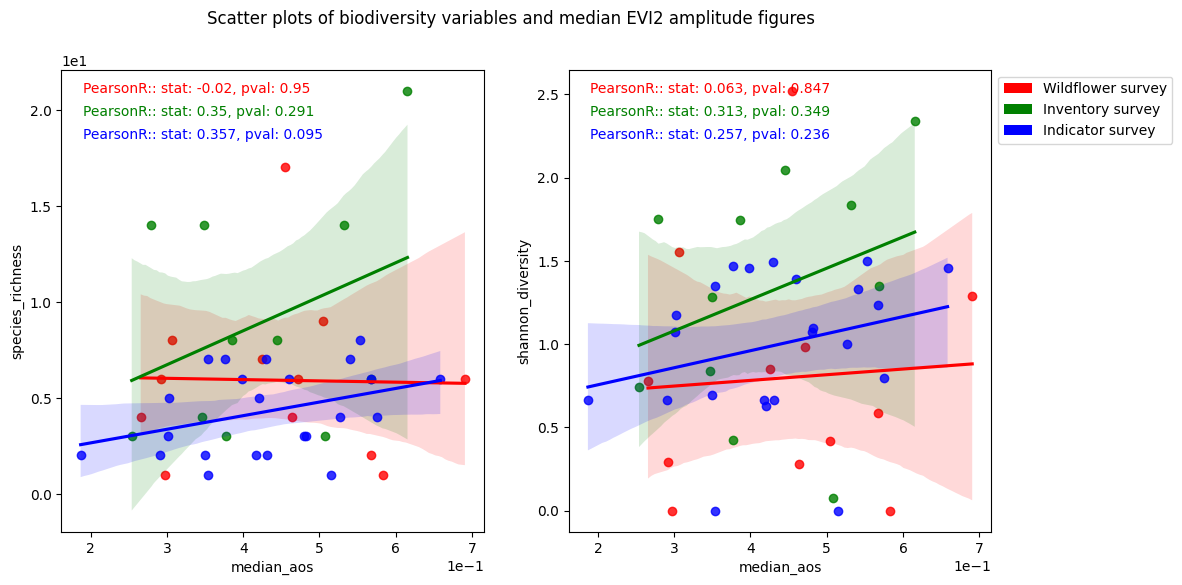

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))

cs = ['red', 'green', 'blue']
survey_levels = ['Wildflower survey', 'Inventory survey', 'Indicator survey']
legend_handles=[]
for i, survey_id in enumerate([87, 154, 155]):
    _species_richness = species_richness[species_richness['survey_id'] == survey_id]
    _shannon_diversity = shannon_diversity[shannon_diversity['survey_id'] == survey_id]
    
    sns.regplot(x='median_aos',y='species_richness', data=_species_richness, fit_reg=True, ax=axs[0], color=cs[i]) 
    axs[0].text(0.05,0.95-i*0.05, 'PearsonR:: stat: {}, pval: {}'.format(round(pearsonr(_species_richness['median_aos'], _species_richness['species_richness']).statistic, 3),
                                                                  round(pearsonr(_species_richness['median_aos'], _species_richness['species_richness']).pvalue, 3)),
               transform = axs[0].transAxes, color=cs[i])
    
    sns.regplot(x='median_aos',y='shannon_diversity', data=_shannon_diversity, fit_reg=True, ax=axs[1], color=cs[i])
    axs[1].text(0.05,0.95-i*0.05, 'PearsonR:: stat: {}, pval: {}'.format(round(pearsonr(_shannon_diversity['median_aos'], _shannon_diversity['shannon_diversity']).statistic, 3),
                                                                  round(pearsonr(_shannon_diversity['median_aos'], _shannon_diversity['shannon_diversity']).pvalue, 3)),
               transform = axs[1].transAxes, color=cs[i])


    legend_handles.append(mpl.patches.Patch(facecolor=cs[i], label=survey_levels[i]))

plt.legend(handles=legend_handles, bbox_to_anchor=[1,1])

plt.suptitle('Scatter plots of biodiversity variables and median EVI2 amplitude figures')
plt.show()

Results are split by survey levels, which call for volunteers to survey different sets of plants:

- "Wildflower Level: surveying at this level involves recording fewer
species. All the species you record are a subset of the species at
Indicator Level.
- Indicator Level: as for the Wildflower Level but using all the species
chosen to indicate different aspects of their habitats. This level gives us
very robust data so where possible we would encourage you to aim to
participate at this level.
- Inventory Level: carrying out the survey at Indicator Level but in
addition recording all other species of vascular plant present within
each plot."

From https://www.npms.org.uk/sites/default/files/PDF/NPMS%20Guidance%20Notes_WEB.pdf.

## Discussion and conclusions

This notebook aimed primarily to reproduce a methodology to assess biodiversity metrics based on remote sensing-derived agricultural productivity parameters. Whilst from a practical standpoint, the methodology was reproduced and adapted to NPMS data, the correlations reported by the authors of [1] were not observed here. That study suggested that agricultural intensity on spring cereal fields reduces vascular plant biodiversity on those fields, and that this can be proxied by remote sensing-derived parameters.

The lack of agreement shown here using NPMS data represents a similar conclusion to that of the last article, in which the large study area (chosen for practical reasons) likely introduced sufficient noise to show biodiversity and productivity measures to be uncorrelated. Here however, a much smaller study area is used on each NPMS location whilst retaining spring cereal cropping activity within those areas, by means of the larger pool of sampling locations in the NPMS dataset. Nonetheless, there remains a very weak correlation between NPMS data and Sentinel-2 parameters. 

Considering the differences between the original and adapted methods remain (which are sufficient to invalidate the conclusion that [1] is simply not repeatable):
- __Study zone definition__: the original study measured biodiversity metrics _inside_ the spring cereal field, whereas NPMS surveys are carried out on field margins.
- __Biodiversity data quality__: the authors of [1] gather biodiversity in a structured and repeatable manner, whereas NPMS data is collected by many volunteers, introducing a degree of subjectivity and variability often associated with citizen science programs.
- __Study region__: the original study focused on agricultural land in a relatively small region of southern Sweden, compared to a much larger national scale NPMS study region.

To further elaborate on the applicability of the method across different study regions, it is likely that vascular plant ecology remains similar within the part of southern Sweden surveyed in [1], whereas on the scale of England there are significant and systematic differences in land cover, climatic zones, and soils (etc.) that may influence plant diversity. A model which incorporates consideration of these factors could be of relevance here, potentially by stratifying sites according to a spatial distribution of relevant variables before examining correlation coefficients. Further work would be required to validate the premise of this suggestion.

On the definition of the study zone at each biodiversity sampling location, it should be said that NPMS linear plots are advised to extend one metre into the cropped field; however that is only the first metre of a 25m x 1m linear survey. Therefore the field margin accounts for the majority of the NPMS sampling area. Similarly, though there is a significant presence of spring cereal cropping in the 100m vicinity of the chosen NPMS locations, the margin may in fact belong to adjacent field and could possibly be separated by a border, ditch or hedge. This represents the most significant difference between the original and adapted methodologies. 

That observation, together with the results of the last notebook on PoMS data, would suggest that the correlation observed between __in-field__ biodiversity metrics and remote sensing parameters (on the same fields) does not extend to biodiversity metrics surveyed in the vicinity of the fields for which remote sensing parameters are calculated. 

However, given the potential issues around data quality and study region definition, that conclusion should be validated by a systematic study on biodiversity in the vicinity of agricultural areas with varying levels of intensity, ideally incorporating cropping beyond just spring cereals.



## References

1. Abdi AM, Carrié R, Sidemo-Holm W, Cai Z, Boke-Olén N, Smith HG, Eklundh L, Ekroos J, Biodiversity Decline With Increasing Crop Productivity in Agricultural Fields Revealed by Satellite Remote Sensing. Ecological Indicators. 2021; 130():108098. https://doi.org/10.1016/j.ecolind.2021.108098.
2. Pescott OL, Walker KJ, Pocock MJO, Jitlal M, Outhwaite CL, Cheffings CM, Harris F, Roy DB. Ecological Monitoring With Citizen Science: The Design and Implementation of Schemes for Recording Plants in Britain and Ireland. Biological Journal of the Linnean Society. 2015; 115(3): 505–521. https://doi.org/10.1111/bij.12581.
3. National Plant Monitoring Scheme (2023). National Plant Monitoring Scheme survey data (2015-2022) NERC EDS Environmental Information Data Centre. https://doi.org/10.5285/f7ef2dc5-2bce-4436-8f65-90f7a99acff2.
4. UK Rural Payments Agency (RPA). Crop Map of England (CROME), 2018 - 2020. Licence: https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/.
5. Trotter L. PhenoloPy Tutorial. https://github.com/lewistrotter/PhenoloPy/blob/main/Phenolopy.ipynb.